In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.fftpack import fft, ifft
from scipy import interpolate as interp
from scipy import signal as sg

In [2]:
sns.set(rc={'figure.figsize':(30,10)})

In [3]:
path = '/media/ke/8tb_part2/FSL_work/SH/SH_003_20190816_edits.txt'

In [4]:
endTidal = pd.read_csv(path, sep='\t|,', header=None, usecols=[0, 1, 2], index_col=False, engine='python')
endTidal = endTidal.rename(columns={0 : 'Time',
                                    1 : 'O2',
                                    2 : 'CO2'})
# need to scale CO2 data is necessary
if endTidal.CO2.max() < 1:
    endTidal.CO2 = endTidal.CO2 * 100

if endTidal.Time.max() < 20:
    endTidal.Time = endTidal.Time * 60

i = 1
diff = abs(endTidal.O2.iloc[i+1] - endTidal.O2.iloc[0])
while diff < 1:
    i += 1
    diff = abs(endTidal.O2.iloc[i+1] - endTidal.O2.iloc[0])

endTidal = endTidal[i:].reset_index(drop=True)

i = len(endTidal)-2
diff = abs(endTidal.O2.iloc[len(endTidal)-1] - endTidal.O2.iloc[i])
while diff < 1:
    i -= 1
    diff = abs(endTidal.O2.iloc[len(endTidal)-1] - endTidal.O2.iloc[i])

endTidal = endTidal[:i].reset_index(drop=True)

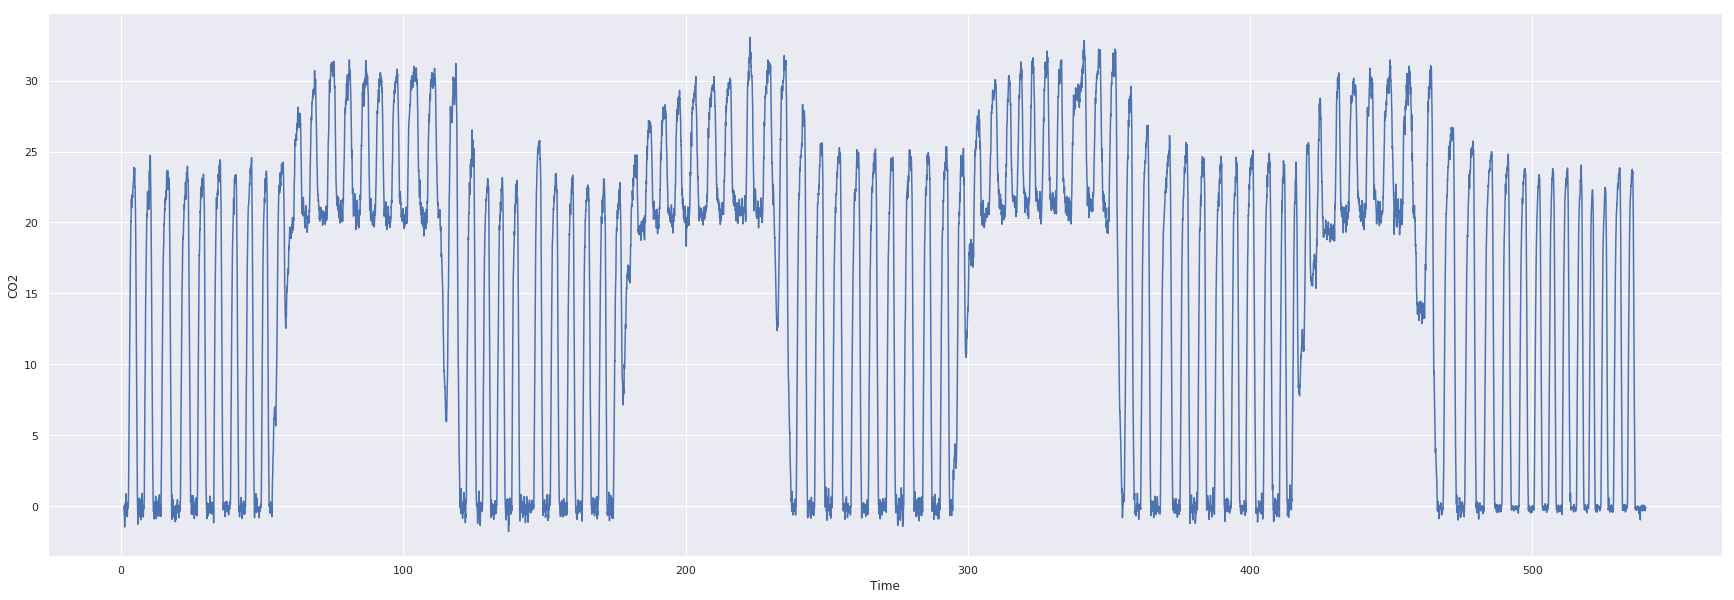

In [5]:
sns.lineplot(x='Time', y='CO2', data=endTidal)
plt.show()

In [6]:
endTidal.CO2 = sg.detrend(endTidal.CO2)

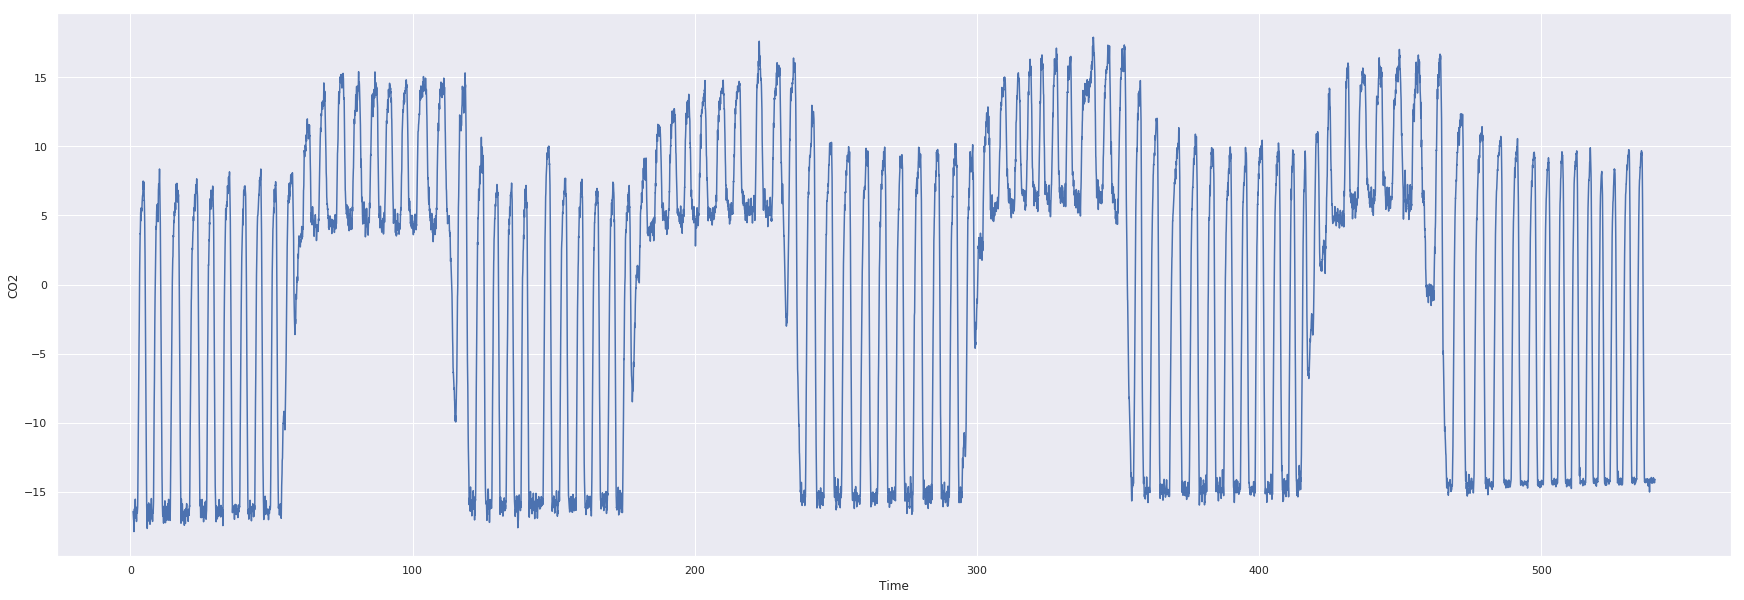

In [7]:
sns.lineplot(x='Time', y='CO2', data=endTidal)
plt.show()

In [8]:
def trim_edges(df):
    i = len(df)-1
    count = 1
    change = abs((df.Data[i-1] - df.Data[i]))
#        print(slope)
    i -= 1

#        print(change)
    while(df.Time[i] > df.Time.max()*0.9):
        pre_change = change
        change = abs((df.Data[i-1] - df.Data[i]))
        diff = abs(change-pre_change)
#            print(diff)
        if diff > 0 and diff < 5e-2:
            count += 1
            i -= 1
        else:
            break
    df.Data[len(df)-count:] = df.Data[len(df)-count]

    i = 0
    count = 1
    change = abs((df.Data[i+1] - df.Data[i]))
#        print(slope)
    i += 1

#        print(change)
    while(df.Time[i] < df.Time.max()*0.1):
        pre_change = change
        change = abs((df.Data[i+1] - df.Data[i]))
        diff = abs(change-pre_change)
#            print(diff)
        if diff > 0 and diff < 5e-2:
            count += 1
            i += 1
        else:
            break
    df.Data[:count] = df.Data[count]

    return df

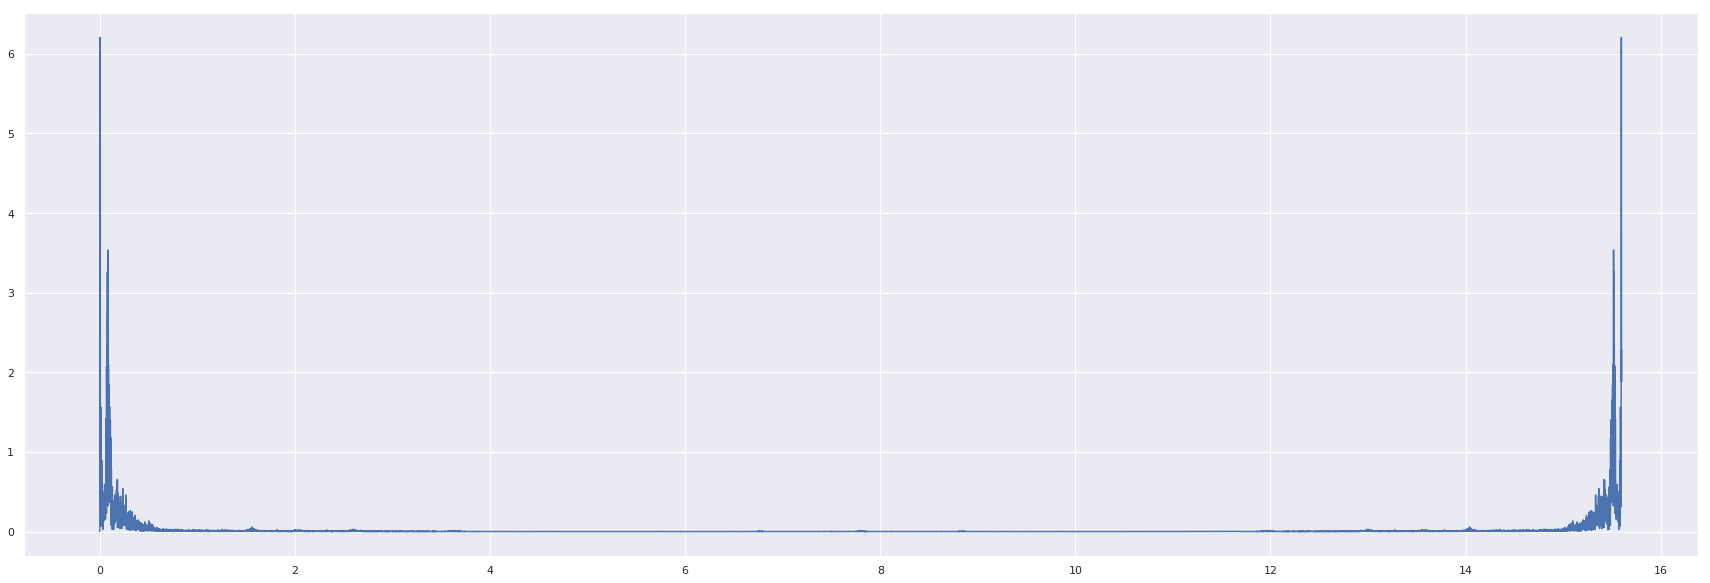

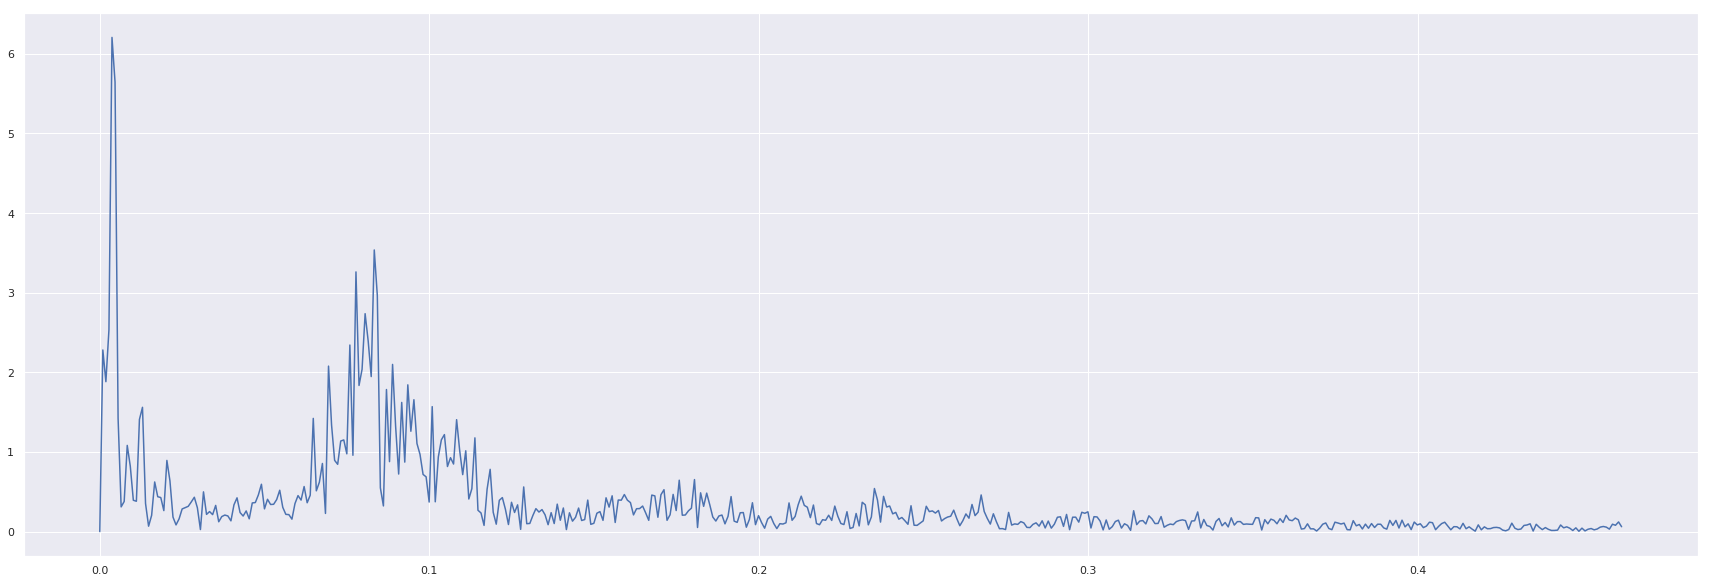

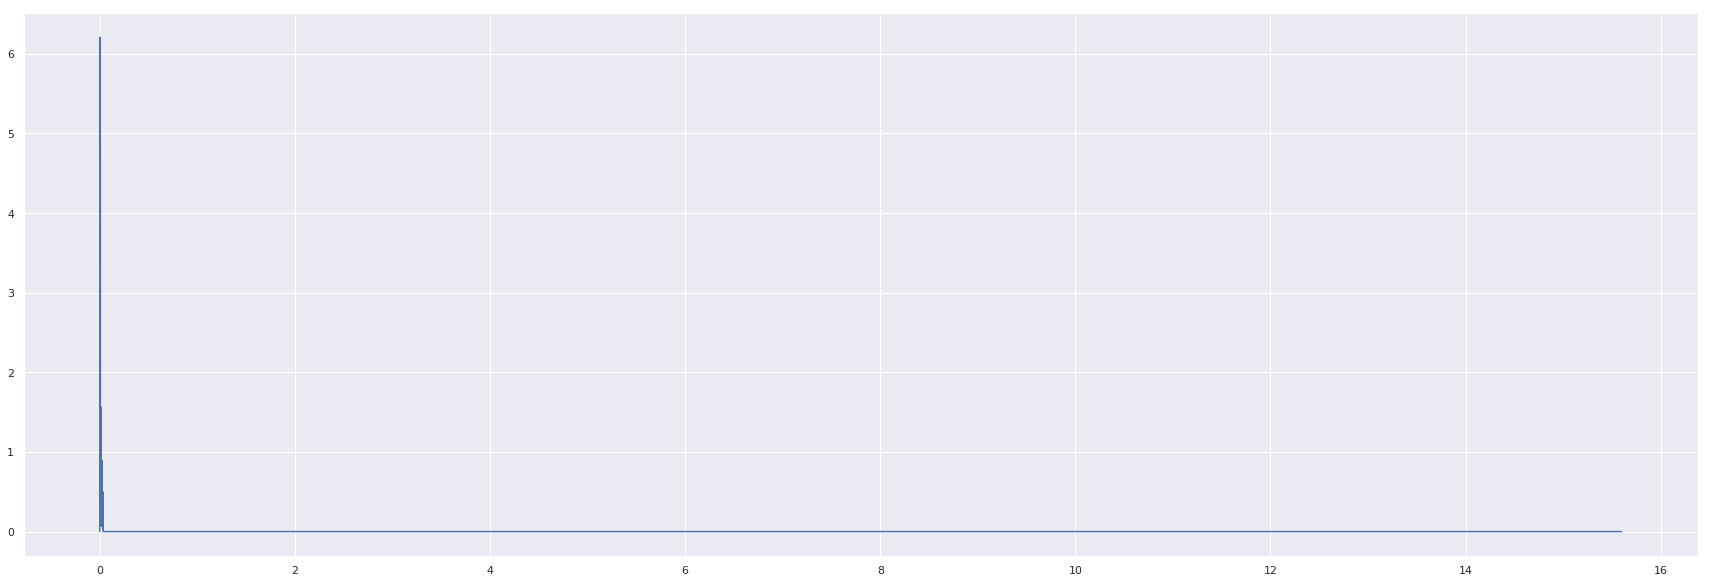

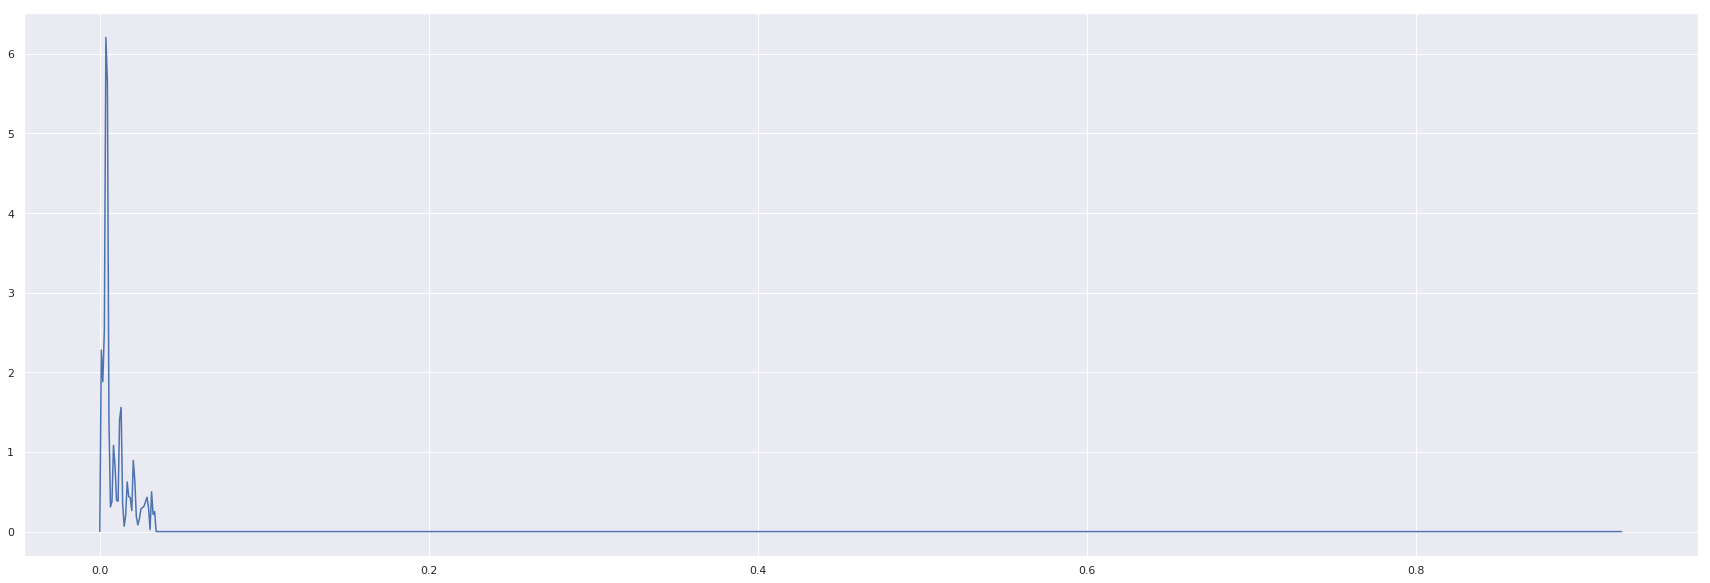

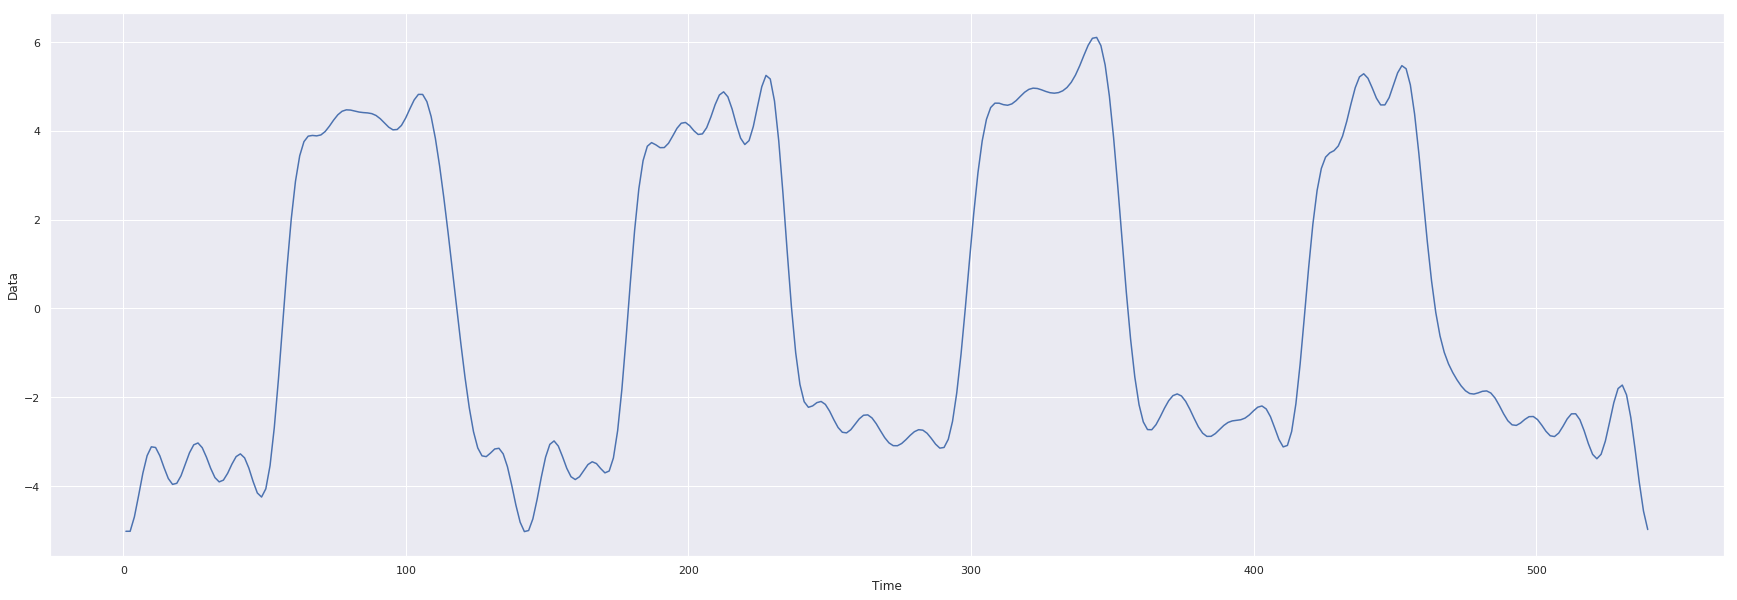

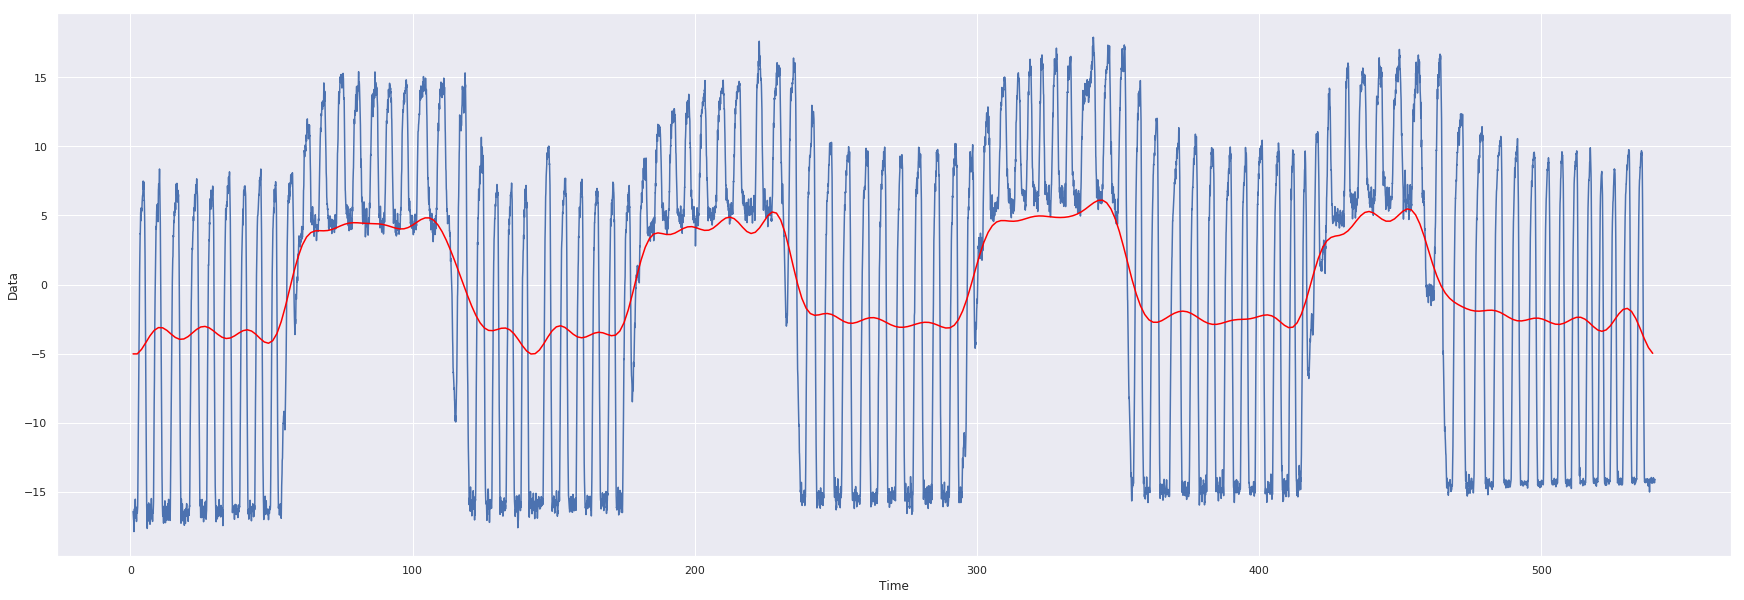

In [19]:
N = len(endTidal)
spacing = endTidal.Time.max()/N
freq = np.linspace(0, 1/(2*spacing), N)
power = fft(endTidal.CO2)
plottable = (2/N * np.abs(power))

sns.lineplot(x=freq, y=plottable)
plt.show()

sns.lineplot(x=freq[:500], y=plottable[:500])
plt.show()

#create a copy of the power_spectra
final = np.copy(power)

gas_r = 0
for i, f in enumerate(freq):
    gas_r = i
    if f > 2/60:
        break

#if f is between bounds, remove associated power
# print(12/60, 25/60)
# for i,f in enumerate(freq):
# #     if f < 2/60:
# #         final[i] = 0
#     if (f >= (2/60) and f <= (25/60)):
#         final[i] = 0
#         final[-i] = 0

# sns.lineplot(x=freq, y=(2/N * np.abs(final)))
# plt.show()

# sns.lineplot(x=freq[:1000], y=(2/N * np.abs(final))[:1000])
# plt.show()

# inverted = ifft(final).real
# resample_ts = np.arange(endTidal.Time.min(), endTidal.Time.max(), 1.5)
# resampler = interp.interp1d(endTidal.Time, inverted, fill_value="extrapolate")

# df = pd.DataFrame({'Time' : resample_ts,
#                    'Data' : resampler(resample_ts)})

# df = trim_edges(df)
# sns.lineplot(x='Time', y='Data', data=df)
# plt.show()
# sns.lineplot(x='Time', y='CO2', data=endTidal)
# sns.lineplot(x='Time', y='Data', data=df, color='red')
# plt.show()

for i,f in enumerate(freq):
    if (f >= (2/60)):
        final[i] = 0

sns.lineplot(x=freq, y=(2/N * np.abs(final)))
plt.show()

sns.lineplot(x=freq[:1000], y=(2/N * np.abs(final))[:1000])
plt.show()

inverted = ifft(final).real
resample_ts = np.arange(endTidal.Time.min(), endTidal.Time.max(), 1.5)
resampler = interp.interp1d(endTidal.Time, inverted, fill_value="extrapolate")

df = pd.DataFrame({'Time' : resample_ts,
                   'Data' : resampler(resample_ts)})

df = trim_edges(df)
sns.lineplot(x='Time', y='Data', data=df)
plt.show()
sns.lineplot(x='Time', y='CO2', data=endTidal)
sns.lineplot(x='Time', y='Data', data=df, color='red')
plt.show()

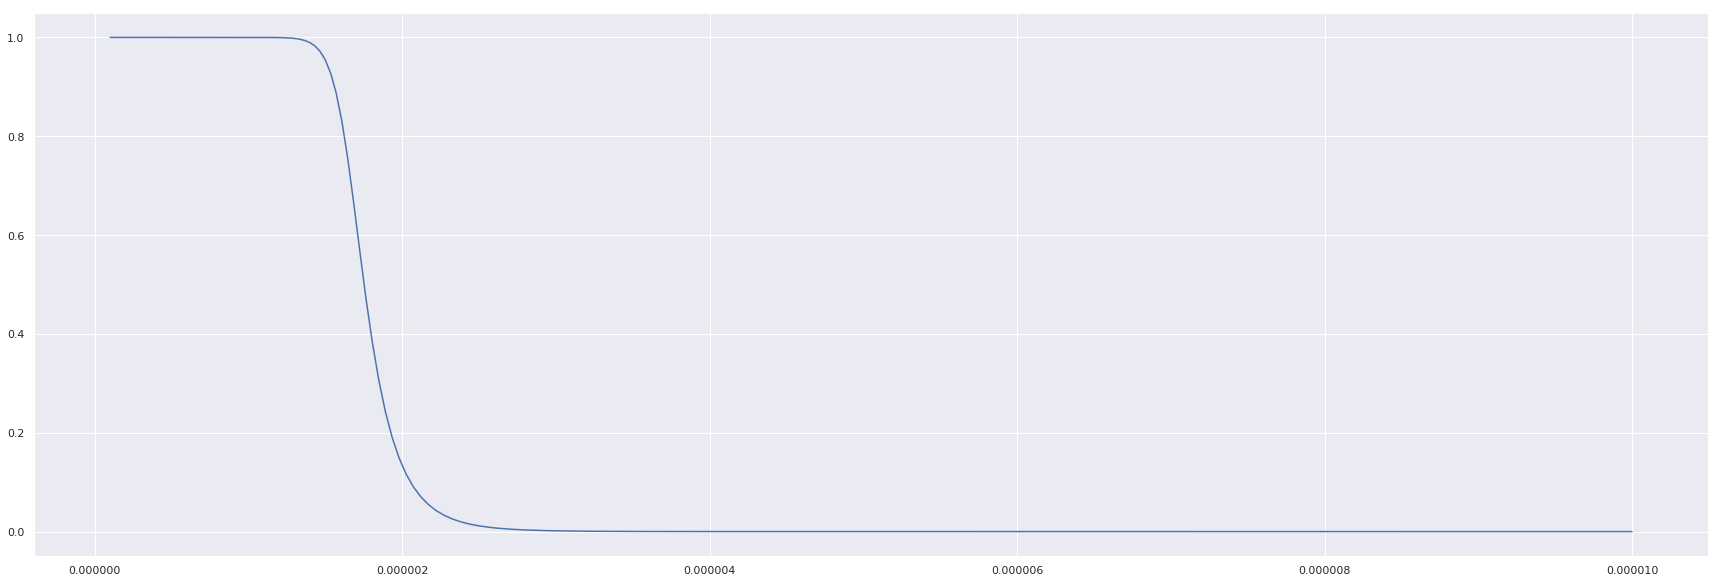

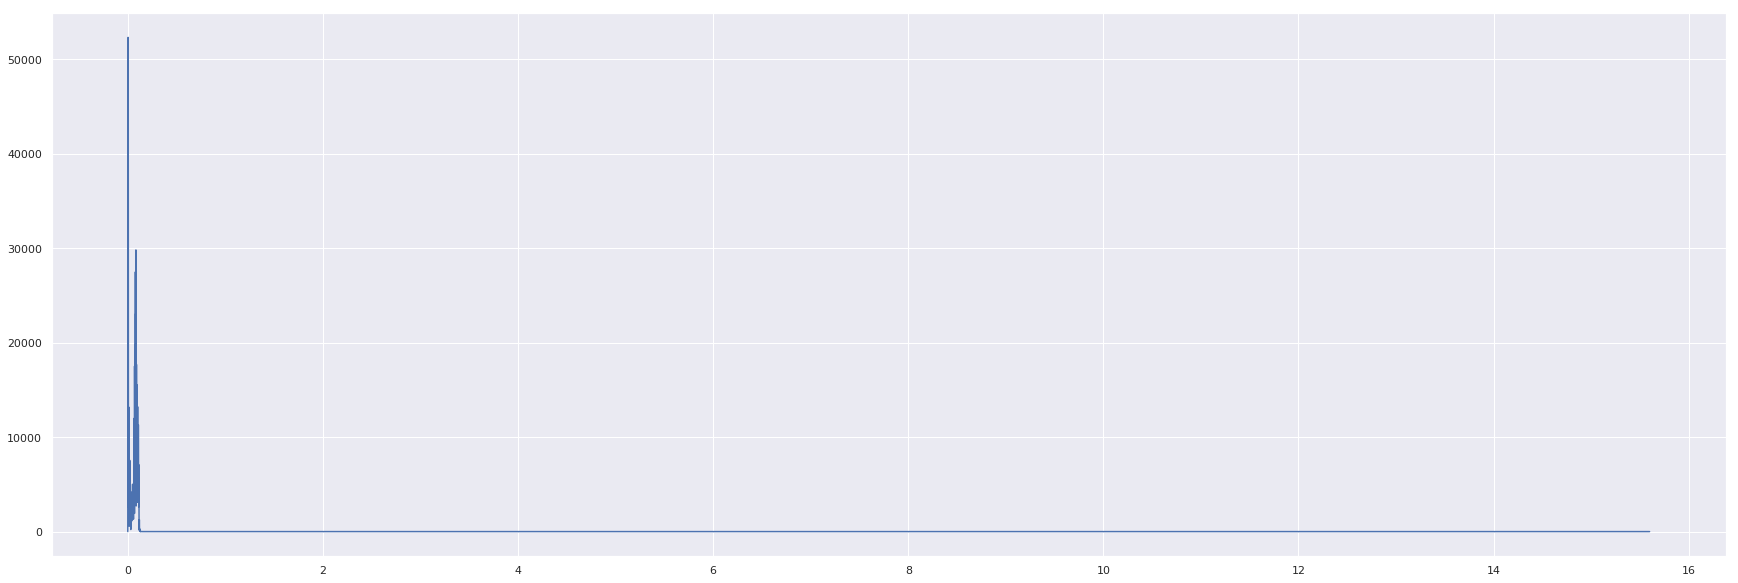

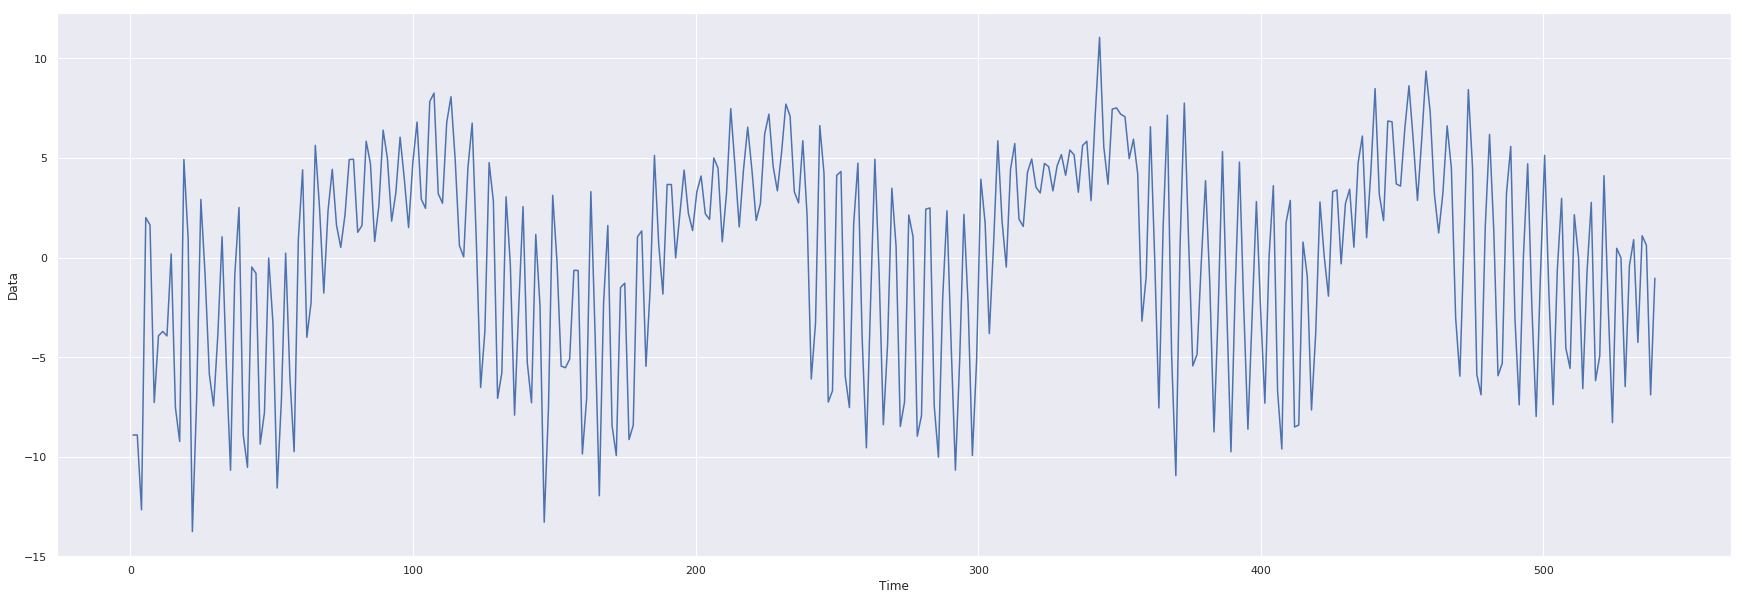

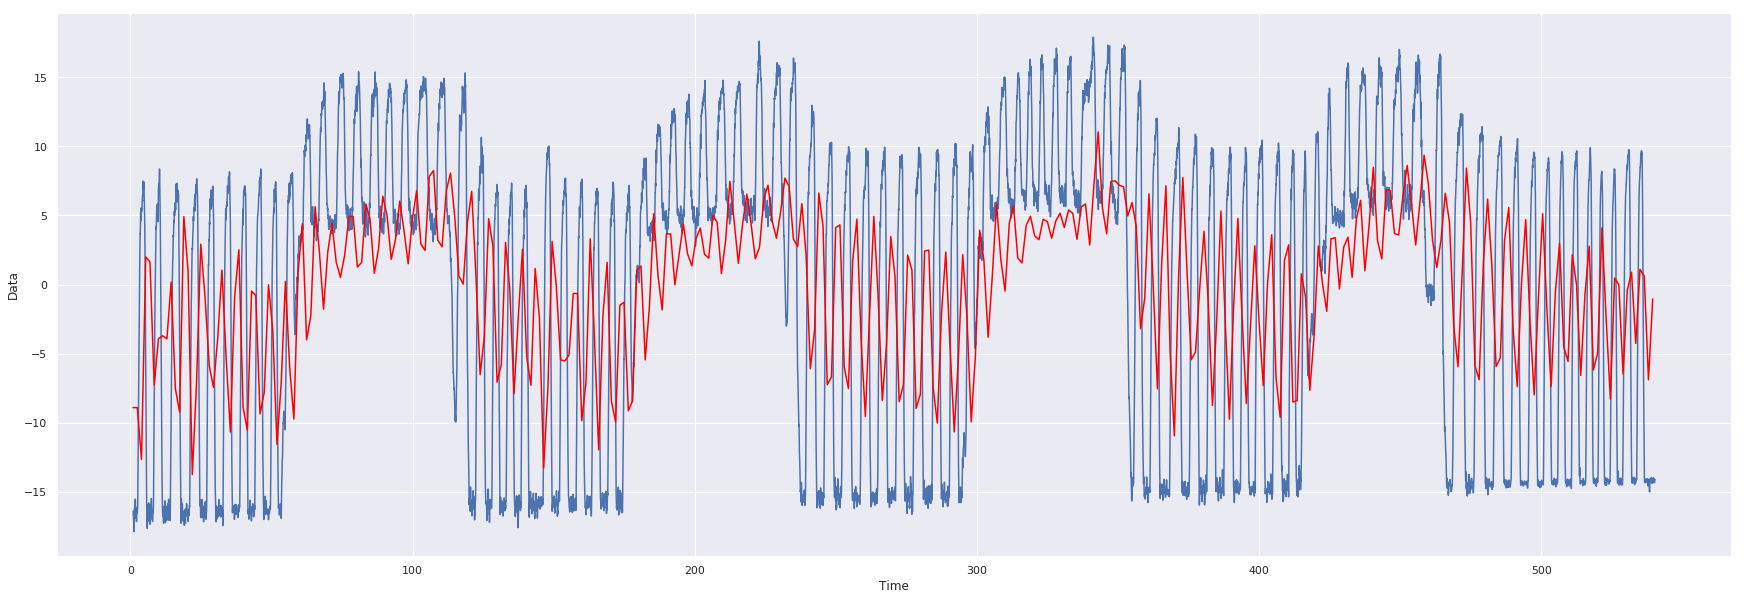

In [43]:

#create a copy of the power_spectra
final = np.copy(power)

b, a = sg.butter(11, 0.0001/60, 'low', analog=True)
w, h = sg.freqs(b, a)
for i,f in enumerate(freq):
    final[i] = final[i] * h[i] if i < len(h) else 0
sns.lineplot(x=w, y=np.abs(h))
plt.show()
filtered = sg.filtfilt(b, a, endTidal.CO2)
sns.lineplot(x=freq, y=np.abs(final))
plt.show()

inverted = ifft(final).real
resample_ts = np.arange(endTidal.Time.min(), endTidal.Time.max(), 1.5)
resampler = interp.interp1d(endTidal.Time, inverted, fill_value="extrapolate")

df = pd.DataFrame({'Time' : resample_ts,
                   'Data' : resampler(resample_ts)})

df = trim_edges(df)
sns.lineplot(x='Time', y='Data', data=df)
plt.show()
sns.lineplot(x='Time', y='CO2', data=endTidal)
sns.lineplot(x='Time', y='Data', data=df, color='red')
plt.show()

5.331754079283823


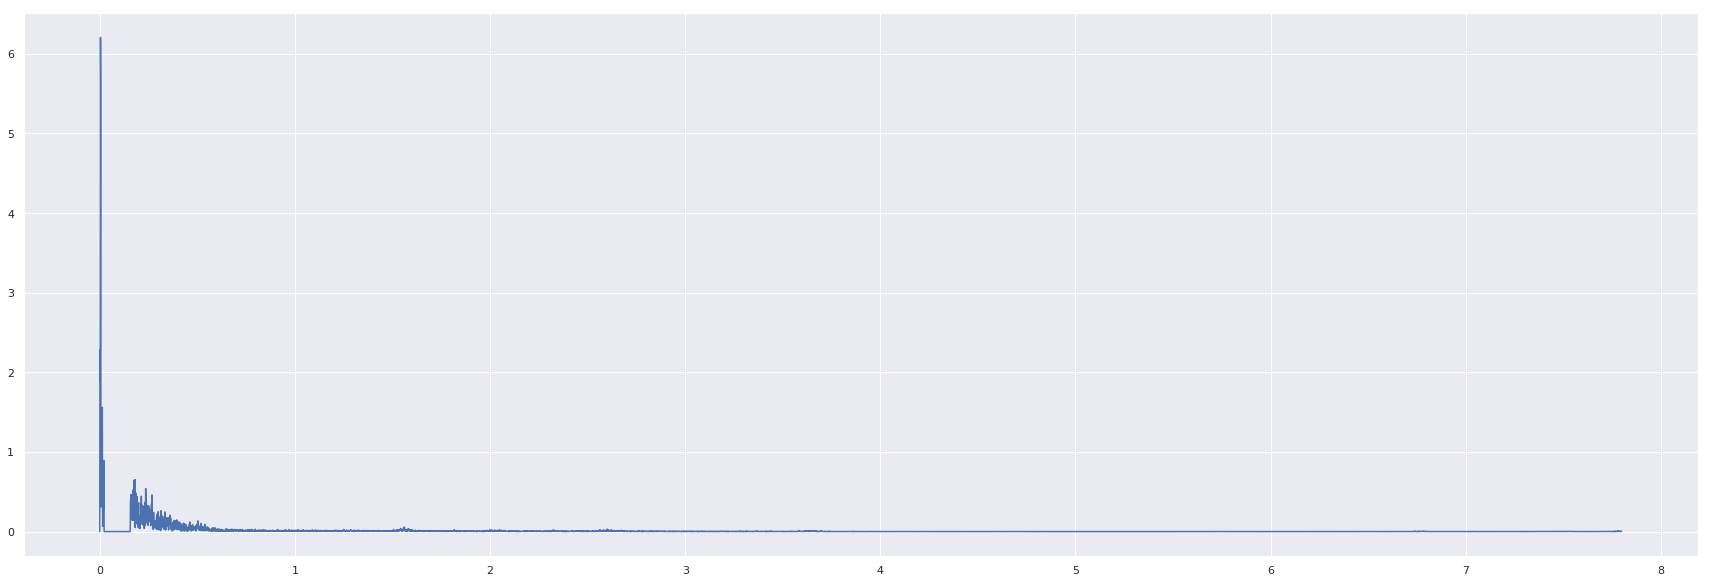

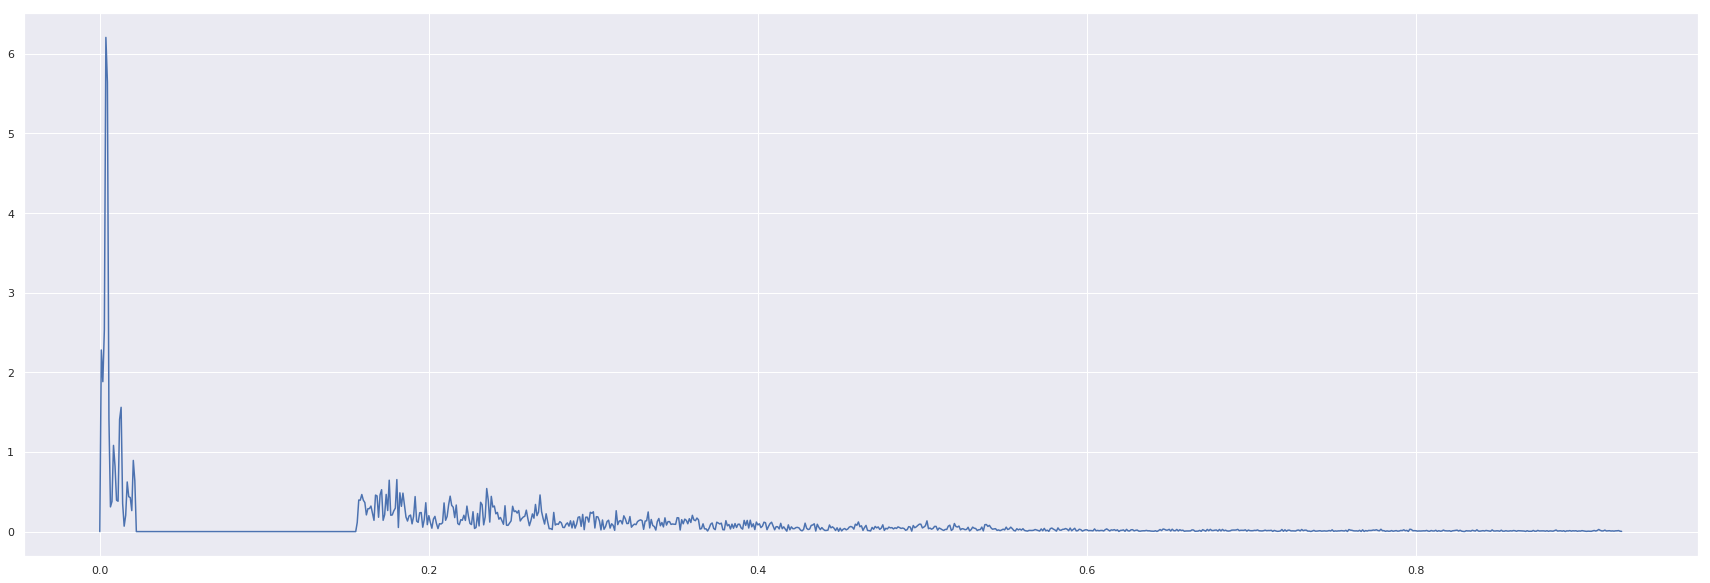

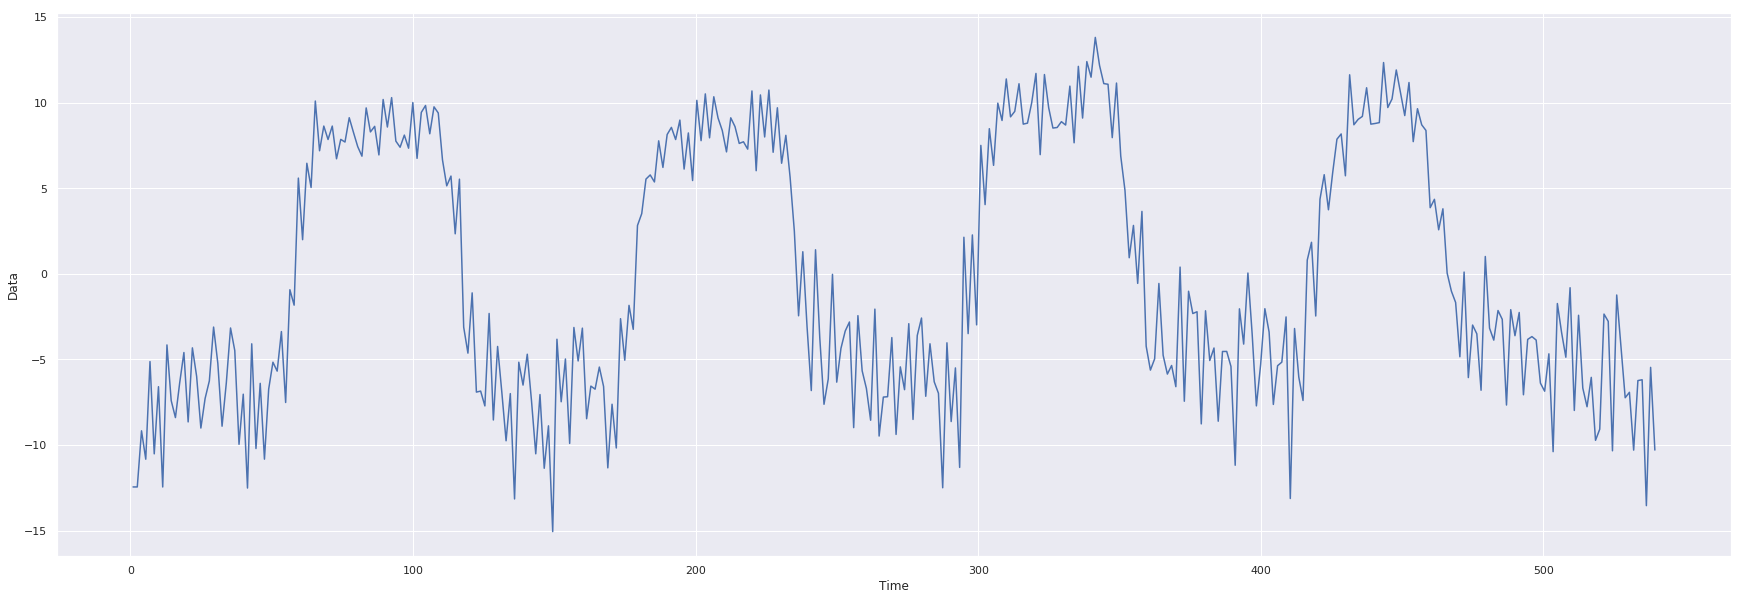

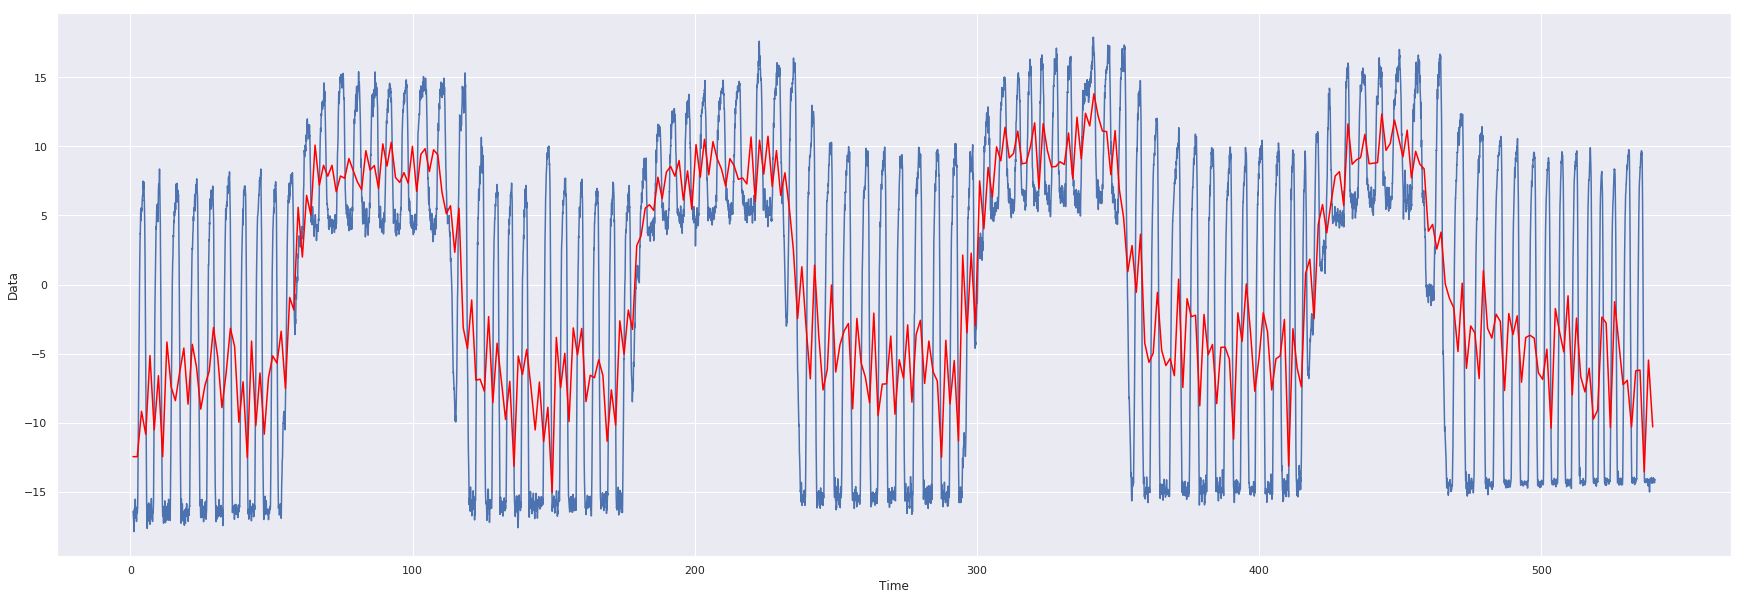

In [15]:

final = np.copy(power)

breath = freq[np.argmax(power[gas_r:N//2]) + gas_r]
print(breath*60)
for i,f in enumerate(freq):
#     if f < 2/60:
#         final[i] = 0
    if (f >= (breath - 4/60) and f <= (breath + 4/60)):
        final[i] = 0
        final[-i] = 0

sns.lineplot(x=freq[:N//2], y=(2/N * np.abs(final))[:N//2])
plt.show()

sns.lineplot(x=freq[:1000], y=(2/N * np.abs(final))[:1000])
plt.show()

inverted = ifft(final).real
resample_ts = np.arange(endTidal.Time.min(), endTidal.Time.max(), 1.5)
resampler = interp.interp1d(endTidal.Time, inverted, fill_value="extrapolate")

df = pd.DataFrame({'Time' : resample_ts,
                   'Data' : resampler(resample_ts)})

df = trim_edges(df)
sns.lineplot(x='Time', y='Data', data=df)
plt.show()
sns.lineplot(x='Time', y='CO2', data=endTidal)
sns.lineplot(x='Time', y='Data', data=df, color='red')
plt.show()

In [ ]:
import os
import glob
import fnmatch
import json
import subprocess
from scipy import signal

In [ ]:
path = '/media/ke/8tb_part2/FSL_work/SH/'
nifti_dir = '/media/ke/8tb_part2/FSL_work/SH_info/'
processed_dir = '/media/ke/8tb_part2/FSL_work/SH_info/BOLD_processed'
freesurfer_t1_dir = '/media/ke/8tb_part2/FSL_work/SH_FST1'
verb = True

In [ ]:
warnings = {'ID' : [],
            'warning' : []}

# all grab all the .txt files in the endtidal folder
txt_files = [file for file in os.listdir(path) if file.upper().endswith('EDITS.TXT')]

if verb:
    print("Constructing dataframe for patients")
#separate patient ID and scan date and pack into dictionary
p_dic = {'Cohort' : [],
         'ID' : [],
         'Date' : [],
         'EndTidal_Path' : []}
for f in txt_files:
    file = f.split('_')
    p_dic['Cohort'].append(file[0].upper())
    p_dic['ID'].append(file[1])
    p_dic['Date'].append(file[2])
    p_dic['EndTidal_Path'].append(path+f)

p_df = pd.DataFrame(p_dic)
#p_df = pd.DataFrame({
#                'Cohort':[f[0:2] for f in txt_files],
#                'ID':[f[3:6] for f in txt_files],
#                'Month':[f[11:13] for f in txt_files],
#                'Day':[f[13:15] for f in txt_files],
#                'Year':[f[7:11] for f in txt_files],
#                'EndTidal_Path': [path+f for f in txt_files]
#             })


#print(p_df.head())
#create patient bold scan listdir (is a list not DataFrame)
#patient_BOLDS_header = [p_df.Cohort[i]+p_df.ID[i]+'_BOLD_'+p_df.Year[i]+p_df.Month[i]+p_df.Day[i]
#                    for i in range(len(p_df))]
patient_BOLDS_header = [p_df.Cohort[i]+p_df.ID[i]+'_BOLD_'+p_df.Date[i]
                    for i in range(len(p_df))]

if verb:
    print('Constructing dataframe that holds all relevant paths')
#get bold and FS paths
nii_paths = {'BOLD_path' : [], 'BOLD_corrected_path': [], 'T1_path' : [], 'meants_path': [], 'Processed_path': [], 'boldFS_exists': []}
for i in range(len(p_df)):
    if verb:
        print('\tGetting paths relavent to',p_df.Cohort[i] + p_df.ID[i] + '_' + p_df.Date[i])
    
    #if bold file doesnt exist then continue
    patient_dir = glob.glob(nifti_dir + p_df.Cohort[i] + p_df.ID[i] + '*' + p_df.Date[i])
    if len(patient_dir) == 0 or not os.path.exists(patient_dir[0] + '/BOLD/'):
        date = p_df.Date[i][-4:] + p_df.Date[i][:-4]
        patient_dir = glob.glob(nifti_dir + p_df.Cohort[i] + p_df.ID[i] + '*' + date)
        if len(patient_dir) == 0 or not os.path.exists(patient_dir[0] + '/BOLD/'):
            
            warnings['ID'].append(p_df.Cohort[i] + p_df.ID[i] + '_' + p_df.Date[i])
            warnings['warning'].append('No BOLD folder')
            
            nii_paths['BOLD_path'].append('')
            nii_paths['BOLD_corrected_path'].append('')
            nii_paths['T1_path'].append('')
            nii_paths['meants_path'].append('')
            nii_paths['Processed_path'].append('')
            nii_paths['boldFS_exists'].append(False)
            if verb:
                print('\t\tNo corresponding BOLD folder')
            continue
        else:
            p_df.Date[i] = date

    patient_dir = patient_dir[0] # patient dir is a list of len 1, need to actual string
    #get all matching files
    b_files = [file for file in os.listdir(patient_dir + '/BOLD/') if file.endswith('.nii')]
    
#    fs_files = [file for file in os.listdir(freesurfer_t1_dir) if file == p_df.Cohort[i]+p_df.ID[i]+'_FS_T1.nii.gz']
#    print(p_df.Cohort[i]+'*'+p_df.ID[i]+'_'+p_df.Date[i]+'_FS_TI.nii*')
    fs_files = [file for file in os.listdir(freesurfer_t1_dir)  if fnmatch.fnmatch(file, p_df.Cohort[i]+'*'+p_df.ID[i]+'_'+p_df.Date[i]+'_FS_T1.nii*')]
#    for file in os.listdir(freesurfer_t1_dir):
#        print(file)
#    exit()
    if not fs_files:
        fs_files = [file for file in os.listdir(freesurfer_t1_dir) if fnmatch.fnmatch(file, p_df.Cohort[i]+p_df.ID[i]+'_FS_T1.nii*')]

    #select and add file to appropriate list
    b_temp = patient_dir +'/BOLD/'+b_files[0] if len(b_files) > 0 else ''
    t_temp = freesurfer_t1_dir+fs_files[0] if len(fs_files) > 0 else ''

    nii_paths['BOLD_path'].append(b_temp)
    nii_paths['T1_path'].append(t_temp)
    nii_paths['boldFS_exists'].append(len(b_files) > 0 and len(fs_files)>0)
    
#    print(fs_files)
    
    if len(fs_files) == 0:
        warnings['ID'].append(p_df.Cohort[i] + p_df.ID[i] + '_' + p_df.Date[i])
        warnings['warning'].append('No FS_T1 file')
        if verb:
            print('\t\tNo corresponding FS_T1 file')

    if(len(b_files) > 0):
        #construct the processed nifti directory
        processed_dir = patient_dir +'/BOLD_processed/'
        
        if(not os.path.exists(processed_dir)):
            os.mkdir(processed_dir)

        #append processed directory to data frame
        nii_paths['Processed_path'].append(processed_dir)

        #run slicetimer to correct for slice timing
        time_temp =  processed_dir+b_temp[b_temp.rfind('/')+1:-4]+'_timed.nii'
        if(not os.path.exists(time_temp+'.gz')):
            if verb:
                print('\t\tNo slice timing correction. Creating timing correction')
            subprocess.run(['slicetimer', '-i', b_temp, '-o', time_temp, '--odd'])
        #print('\n', cor_temp, '\n')

        # optional (motion correction)
        cor_temp = time_temp[:-4]+'_demotioned.nii'
        if(not os.path.exists(cor_temp+'.gz')):
            if verb:
                print('\t\tNo motion correction. Creating motion correction')
            subprocess.run(['mcflirt', '-in', time_temp, '-out', cor_temp])


        #add path of corrected nifti
        nii_paths['BOLD_corrected_path'].append(cor_temp)

        # extract the brain using BET
        brain_path = cor_temp[:-4]+'_brain.nii'
        if(not os.path.exists(brain_path+'.gz')):
            if verb:
                print('\t\tNo BET. Creating BET')
            subprocess.run(['bet', cor_temp, brain_path, '-F'])

        # get meants from BET
        meants_path = processed_dir+'/meants.txt'
        nii_paths['meants_path'].append(meants_path)
        if(not os.path.exists(meants_path)):
            if verb:
                print('\t\tNo meants. Creating meants')
            subprocess.run(['fslmeants', '-i', brain_path, '-o', meants_path])
    else:
        warnings['ID'].append(p_df.Cohort[i] + p_df.ID[i] + '_' + p_df.Date[i])
        warnings['warning'].append('No BOLD file')
        
        nii_paths['Processed_path'].append('')
        nii_paths['BOLD_corrected_path'].append('')
        nii_paths['meants_path'].append('')
        if verb:
            print('\t\tNo corresponding BOLD file')
    if verb:
        print('\tAll relavent files grabbed')
        
if verb:
    print('Concatenating patient dataframe with path dataframe')
#append bold, FS paths, and conditional to p_df
p_df = pd.concat((p_df, pd.DataFrame(nii_paths)), axis=1)

if verb:
    print('Dropping patients that have missing BOLD')

#drop all false conditional rows and conditional column and reset indeces
p_df = p_df[p_df.boldFS_exists != False].drop('boldFS_exists', axis = 1)
p_df = p_df.reset_index(drop=True)


if verb:
    print('Getting the TR for each patient')
#get json files and read CSV
tr_dict = {'TR' : [], 'eff_TR' : [] }

for b_path in p_df.BOLD_path:
#    print(b_path[:-4]+'.json')
    with open(b_path[:-4]+'.json', 'r') as j_file:
        data = json.load(j_file)
        #print(data['RepetitionTime'])
        tr = data['RepetitionTime']
        tr_dict['TR'].append(tr)
        eff_tr = tr * 2 if tr < 1.5 else 1.5
        tr_dict['eff_TR'].append(eff_tr)

p_df = pd.concat((p_df, pd.DataFrame(tr_dict)), axis=1)
#print('\n',p_df)

#get number of volumes
#run fslinfo and pipe -> python buffer -> replace \n with ' ' -> split into list -> choose correct index -> convert string to int
if verb:
    print('Getting the dimension of the BOLD for each patient with fslinfo')
p_df["Volumes"] = [int(subprocess.run(['fslinfo' ,b_path], stdout=subprocess.PIPE).stdout.decode('utf-8').replace('\n',' ').split()[9]) for b_path in p_df.BOLD_path]

if verb:
    print('Checking total volume for each patient')
    
warning = p_df[p_df.TR != 1.5]
warning = warning.reset_index(drop=True)
#print(warning)
for i in range(len(warning)):
#    print(i)
    warnings['ID'].append(warning.Cohort[i] + warning.ID[i] + '_' + warning.Date[i])
    warnings['warning'].append('TR != 1.5')
    print('\t\t' + warning.iloc[i].Cohort + warning.iloc[i].ID + '_' + warning.iloc[i].Date + ' has a TR != 1.5')
    
p_df = p_df[p_df.TR == 1.5]

#choose non-trivial bold series
#warning_2 = p_df[p_df.Volumes < 150]
#for i in range(len(warning_2)):
#    print('\t\t' + warning_2[i].Cohort + warning_2[i].ID + '_' + warning_2[i].Date + 'has a total volume < 150')
#print('\np_df w/ dim > 150\n',p_df.head())


In [ ]:
def fourier_trans(time_series, data, N):
    """
    returns a tuple: (frequency domain, Power spectra, abs(power_spectra))

    spacing = the distance between data points
    data = series to be analyzed
    """
    
    spacing = time_series.max()/N
    #create freq_dom from timestep
    freq_dom = np.linspace(0, 1/(2*spacing), N)
    #perform fft
    power_spectra = fft(data)
    #abs(fft) cut in half
    plottable_spectra = (2/N * np.abs(power_spectra))
    return (freq_dom,power_spectra,plottable_spectra)


In [ ]:
ET_dict = {'ETO2' : [], 'ETCO2' : [], 'ET_exists' : [], 'Cohort' : [], 'ID' : [], 'Date' : [],
           'O2_shift' : [], 'CO2_shift' : [], 'coeffs' : [], 'r' : [], 'p_value' : []}

to_drop = []

key = 'f_'

for f_path, vol, cohort, id, date, b_path, p_path, meants_path, tr in zip(p_df.EndTidal_Path, p_df.Volumes, p_df.Cohort, p_df.ID, p_df.Date,
                                                                          p_df.BOLD_corrected_path, p_df.Processed_path, p_df.meants_path, p_df.eff_TR):
    if not os.path.exists(f_path[:-4]):
        os.mkdir(f_path[:-4])

    ##path made and stored in p_df.Processed_path
    ##pre-running slicetimer and mcflirt (motion correction) as we create bold paths

    #perfrom cleaning and load into p_df
    #load data into DataFrame
    ET_dict['Cohort'].append(cohort)
    ET_dict['ID'].append(id)
    ET_dict['Date'].append(date)
    endTidal = pd.read_csv(f_path, sep='\t|,', header=None, usecols=[0, 1, 2], index_col=False, engine='python')
    endTidal = endTidal.rename(columns={0 : 'Time',
                                        1 : 'O2',
                                        2 : 'CO2'})
    #drop rows with missing cols
    endTidal = endTidal.dropna()


    #skip if DataFrame is empty
    if endTidal.empty:
        os.rmdir(f_path[:-4])
        ET_dict['ETO2'].append('')
        ET_dict['ETCO2'].append('')
        ET_dict['ET_exists'].append(False)
        print("\tpatient: ", cohort + id + '_' + date, "has empty end-tidal")
        continue

    scan_time = (vol-3) * tr

    meants = np.loadtxt(meants_path, delimiter='\n')[3:]
    time_pts = np.arange(0, scan_time, tr)
        
    #generate cleaned data paths
    save_O2 = f_path[:-4]+'/'+key+'O2_contrast.txt'
    save_CO2 = f_path[:-4]+'/'+key+'CO2_contrast.txt'
    save = True
    
    #check if the save_files already exist
    if(os.path.exists(save_O2) and os.path.exists(save_CO2) and not over):
        save = False
        if(verb):
            print('\tID: ', cohort + id + '_' + date," \tProcessed gas files already exist")
        ET_dict['ETO2'].append(save_O2)
        ET_dict['ETCO2'].append(save_CO2)
        ET_dict['ET_exists'].append(True)
        processed_O2 = np.loadtxt(save_O2)
        processed_CO2 = np.loadtxt(save_CO2)

    # need to scale CO2 data is necessary
    if endTidal.CO2.max() < 1:
        endTidal.CO2 = endTidal.CO2 * 100

#        plt.plot(endTidal.CO2)
#        plt.show()

    if endTidal.Time.max() < 20:
        endTidal.Time = endTidal.Time * 60

    i = 1
    diff = abs(endTidal.O2.iloc[i+1] - endTidal.O2.iloc[0])
    while diff < 2:
        i += 1
        diff = abs(endTidal.O2.iloc[i+1] - endTidal.O2.iloc[0])

    endTidal = endTidal[i:].reset_index(drop=True)

    i = len(endTidal)-2
    diff = abs(endTidal.O2.iloc[len(endTidal)-1] - endTidal.O2.iloc[i])
    while diff < 2:
        i -= 1
        diff = abs(endTidal.O2.iloc[len(endTidal)-1] - endTidal.O2.iloc[i])

    endTidal = endTidal[:i].reset_index(drop=True)

    meants = signal.savgol_filter(meants, 5, 3)

#        endTidal.CO2 = signal.savgol_filter(endTidal.CO2, 35, 3)
    endTidal.CO2 = signal.detrend(endTidal.CO2)
    endTidal.O2 = signal.detrend(endTidal.O2)
    
    print(cohort+id+'_'+date)
    
#     sns.lineplot(x=endTidal.Time, y=endTidal.CO2)
    
#     fs = len(endTidal.CO2)/endTidal.Time.max()
#     fc = 30/60
#     w = fc / (fs / 2)
#     b, a = signal.butter(4, 0.8, 'low', analog='True')
#     filtered = signal.filtfilt(b, a, endTidal.CO2)
    
#     sns.lineplot(x=endTidal.Time, y=filtered)
#     plt.show()
    
    N = len(endTidal)
    freq, power, plottable = fourier_trans(endTidal.Time, endTidal.CO2, N)

    sns.lineplot(x=freq, y=plottable)
plt.show()